In [1]:
import pyarrow as pa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline

Load signal and background files

In [75]:
identifier = '20220215_best_iso'
identifier = '20220217_0pt_best_iso'

sig = pd.read_feather('/home/grabanal/minitree/{}_VVZ.arrow'.format(identifier))
bkg = pd.read_feather('/home/grabanal/minitree/{}_FULLBG.arrow'.format(identifier))

Simple check

In [76]:
print('VVZ signal yield:', sum(sig.wgt))
print('background yield:', sum(bkg.wgt))

VVZ signal yield: 30.06203421101435
background yield: 2499.154924596728


Define basic functions

In [77]:
def yield_and_error(df):
    '''
    input: 
    df  : dataframe
    
    output:
    yield (significance, error)
    '''
    Y  = -1
    dY = -1
    Y  = sum(df.wgt)
    dY = np.sqrt(sum(df.wgt**2))
    # return tuple
    return Y, dY

def significance_and_error(S, dS, B, dB):
    '''
    input: 
    S  : signal
    dS : signal error
    B  : background
    dB : background error
    
    output:
    tuple (significance, error)
    '''
    # FAKE SIGNIFICANCE
#     significance = S/np.sqrt(B)
#     error        = np.sqrt( 1/B*(dS**2) + (S**2)/(4*B**3)*(dB**2) )
#     return significance, error
    
    # REAL SIGNIFICANCE
    # if a quantity is negative, return 0
    if (S<=0 or B<=0):
        return 0, 0
    # calculate the significance and its error
    significance = np.sqrt( 2*((S + B)*np.log(1 + S/B) - S) )
    dSignifdS    = np.log(1 + S/B)/significance
    dSignifdB    = ( np.log(1 + S/B) - S/B )/significance
    error        = np.sqrt( (dSignifdS*dS)**2 + (dSignifdB*dB)**2 )
    # return tuple
    return significance, error

def add_in_quadrature_3( XdX, YdY, ZdZ ):
    '''
    input: 
    XdX : tuple (significance, error)
    YdY : tuple (significance, error)
    ZdZ : tuple (significance, error)
    
    output:
    tuple (significance, error) added in quadrature
    '''
    # unpack the significances
    x, dx = XdX
    y, dy = YdY
    z, dz = ZdZ
    # calculate the addition in quadrature and its error
    quadrature_sum   = np.sqrt(x**2 + y**2 + z**2)
    A                = (x**2)*(dx**2) + (y**2)*(dy**2) + (z**2)*(dz**2)
    B                = (x**2) + (y**2) + (z**2)
    if (quadrature_sum==0):
        return 0, 0
    quadrature_error = np.sqrt( A / B )
    # return tuple
    return quadrature_sum, quadrature_error

def total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        m_list.append(significance_and_error(S, dS, B, dB))
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    return significance, error

def print_total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        if (sr == 0):
            print("Region 4ℓ-SF-inZ:")
        if (sr == 1):
            print("Region 4ℓ-SF-noZ:")
        if (sr == 2):
            print("Region 4ℓ-DF:")
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        print("--- S = {:.2f} ± {:.2f} ".format(S, dS))
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        print("--- B = {:.2f} ± {:.2f} ".format(B, dB))
        significance, error = significance_and_error(S, dS, B, dB)
        print("--- significance = {:.2f} ± {:.2f} ".format(significance, error))
        m_list.append((significance, error))
        print()
        
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    print("Total significance in quadrature = {:.2f} ± {:.2f} ".format(significance, error))

Simple check

In [78]:
print_total_significance_and_error(sig, bkg)

Region 4ℓ-SF-inZ:
--- S = 9.27 ± 0.06 
--- B = 1854.59 ± 6.06 
--- significance = 0.22 ± 0.00 

Region 4ℓ-SF-noZ:
--- S = 9.60 ± 0.11 
--- B = 582.17 ± 7.15 
--- significance = 0.40 ± 0.01 

Region 4ℓ-DF:
--- S = 11.19 ± 0.15 
--- B = 62.39 ± 5.90 
--- significance = 1.38 ± 0.06 

Total significance in quadrature = 1.45 ± 0.06 


In [6]:
n_qualities     = 9
n_iso_electrons = 6
n_iso_muons     = 12
n_iso = n_iso_electrons*n_iso_muons

# $p_T$ scan

We have 4 leptons, and we can make a scan using $n$ possible cuts. The amount of possible combinations will not be $n^4$ since always ${p_T}_1 \geq {p_T}_2 \geq {p_T}_3 \geq {p_T}_4$. The actual number of possible combinations will be:
$$ \frac{n(n+1)(n+2)(n+3)}{24} \, \textrm{which is} \leq n^4 $$

You can load a dataframe from file or do a full event loop which is slow

In [8]:
pt_scan_df = pd.read_csv('csv/pt_scan_df.csv')

In [79]:
# I will just scan over the DF region because it's faster!
this_sig = sig[sig.SR == 2].copy()
this_bkg = bkg[bkg.SR == 2].copy()

In [80]:
this_sig.pt_4

30         9664.405273
32        13720.771484
66        27851.761719
116        6301.945801
160       46541.195312
              ...     
107683    40547.082031
107737     5528.276855
107803    17691.474609
107833    37128.558594
107849    25454.117188
Name: pt_4, Length: 16855, dtype: float32

In [81]:
min_pt = 0
max_pt = 50
cuts = np.linspace(min_pt,max_pt,max_pt-min_pt+1)
cuts

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

In [82]:
pt_scan_df = pd.DataFrame()

cuts *= 1000 # because we want GeV
n_cuts = len(cuts)

for n, df in zip([0,1],[this_sig, this_bkg]):
    
    if (n == 0):
        print("--- analyzing the signal")
    if (n == 1):
        print("--- analyzing the background")
        
    total = (int)(n_cuts*(n_cuts+1)*(n_cuts+2)*(n_cuts+3)/24)
    
    y        = np.zeros((3,total)) # for each SR
    y_err    = np.zeros((3,total)) # for each SR
    list_pt_4 = np.zeros(total) 
    list_pt_3 = np.zeros(total) 
    list_pt_2 = np.zeros(total) 
    list_pt_1 = np.zeros(total) 
    
    counter = -1
    for pt_4_cut in cuts:
            
        pt_4_df = df.copy()
        pt_4_df = pt_4_df[pt_4_df.pt_4 >= pt_4_cut] 
        
        for pt_3_cut in cuts[cuts >= pt_4_cut]:
            
            pt_3_df = pt_4_df.copy()
            pt_3_df = pt_3_df[pt_3_df.pt_3 >= pt_3_cut] 
            
            for pt_2_cut in cuts[cuts >= pt_3_cut]:

                pt_2_df = pt_3_df.copy()
                pt_2_df = pt_2_df[pt_2_df.pt_2 >= pt_2_cut]
                
                for pt_1_cut in cuts[cuts >= pt_2_cut]:

                    pt_1_df = pt_2_df.copy()
                    pt_1_df = pt_1_df[pt_1_df.pt_1 >= pt_1_cut] 
        
                    counter += 1
                    if (counter % 1000 == 0):
                        print('counter = ', counter)
                
                    for SR in [0,1,2]:

                        y[SR][counter]     = sum(pt_1_df[pt_1_df.SR==SR]['wgt'])
                        y_err[SR][counter] = sum(pt_1_df[pt_1_df.SR==SR]['wgt']**2)
                        
                        list_pt_4[counter] = pt_4_cut
                        list_pt_3[counter] = pt_3_cut
                        list_pt_2[counter] = pt_2_cut
                        list_pt_1[counter] = pt_1_cut

    y_err[0] = np.sqrt(y_err[0])
    y_err[1] = np.sqrt(y_err[1])
    y_err[2] = np.sqrt(y_err[2])

    # Saving information:
    if (n == 0):
        pt_scan_df['SF-inZ-signal']     = pd.Series(y[0])
        pt_scan_df['SF-inZ-signal-err'] = pd.Series(y_err[0])
        pt_scan_df['SF-noZ-signal']     = pd.Series(y[1])
        pt_scan_df['SF-noZ-signal-err'] = pd.Series(y_err[1])
        pt_scan_df['DF-signal']         = pd.Series(y[2])
        pt_scan_df['DF-signal-err']     = pd.Series(y_err[2])
        pt_scan_df['signal']            = pd.Series(y[0]+y[1]+y[2])
        pt_scan_df['signal-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
    if (n == 1):
        pt_scan_df['SF-inZ-background']     = pd.Series(y[0])
        pt_scan_df['SF-inZ-background-err'] = pd.Series(y_err[0])
        pt_scan_df['SF-noZ-background']     = pd.Series(y[1])
        pt_scan_df['SF-noZ-background-err'] = pd.Series(y_err[1])
        pt_scan_df['DF-background']         = pd.Series(y[2])
        pt_scan_df['DF-background-err']     = pd.Series(y_err[2])
        pt_scan_df['background']            = pd.Series(y[0]+y[1]+y[2])
        pt_scan_df['background-err']        = pd.Series(np.sqrt(y_err[0]**2 + y_err[1]**2 + y_err[2]**2))
        
    pt_scan_df['pt_4']     = pd.Series(list_pt_4)
    pt_scan_df['pt_3']     = pd.Series(list_pt_3)
    pt_scan_df['pt_2']     = pd.Series(list_pt_2)
    pt_scan_df['pt_1']     = pd.Series(list_pt_1)
        
        
# Calculating the significances
print("Calculating the significances")
significances = [[],[],[],[]] 
errors = [[],[],[],[]]

for choice in pt_scan_df.index:

    # SF-inZ
    significance, error = significance_and_error(pt_scan_df.at[choice,'SF-inZ-signal'], \
                                                 pt_scan_df.at[choice,'SF-inZ-signal-err'], \
                                                 pt_scan_df.at[choice,'SF-inZ-background'], \
                                                 pt_scan_df.at[choice,'SF-inZ-background-err'])
    significances[0].append(significance)
    errors[0].append(error)
    # SF-noZ
    significance, error = significance_and_error(pt_scan_df.at[choice,'SF-noZ-signal'], \
                                                 pt_scan_df.at[choice,'SF-noZ-signal-err'], \
                                                 pt_scan_df.at[choice,'SF-noZ-background'], \
                                                 pt_scan_df.at[choice,'SF-noZ-background-err'])
    significances[1].append(significance)
    errors[1].append(error)
    # DF
    significance, error = significance_and_error(pt_scan_df.at[choice,'DF-signal'], \
                                                 pt_scan_df.at[choice,'DF-signal-err'], \
                                                 pt_scan_df.at[choice,'DF-background'], \
                                                 pt_scan_df.at[choice,'DF-background-err'])
    significances[2].append(significance)
    errors[2].append(error)
    # Quadrature
    significance, error = add_in_quadrature_3((significances[0][-1], errors[0][-1]), 
                                              (significances[1][-1], errors[1][-1]),
                                              (significances[2][-1], errors[2][-1]),)
    significances[3].append(significance)
    errors[3].append(error)
    
pt_scan_df['SF-inZ-significance']     = pd.Series(significances[0])
pt_scan_df['SF-inZ-significance-err'] = pd.Series(errors[0])
pt_scan_df['SF-noZ-significance']     = pd.Series(significances[1])
pt_scan_df['SF-noZ-significance-err'] = pd.Series(errors[1])
pt_scan_df['DF-significance']         = pd.Series(significances[2])
pt_scan_df['DF-significance-err']     = pd.Series(errors[2])
pt_scan_df['significance']            = pd.Series(significances[3])
pt_scan_df['significance-err']        = pd.Series(errors[3])
print("--- Done!")

--- analyzing the signal
counter =  0
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
co

counter =  148000
counter =  149000
counter =  150000
counter =  151000
counter =  152000
counter =  153000
counter =  154000
counter =  155000
counter =  156000
counter =  157000
counter =  158000
counter =  159000
counter =  160000
counter =  161000
counter =  162000
counter =  163000
counter =  164000
counter =  165000
counter =  166000
counter =  167000
counter =  168000
counter =  169000
counter =  170000
counter =  171000
counter =  172000
counter =  173000
counter =  174000
counter =  175000
counter =  176000
counter =  177000
counter =  178000
counter =  179000
counter =  180000
counter =  181000
counter =  182000
counter =  183000
counter =  184000
counter =  185000
counter =  186000
counter =  187000
counter =  188000
counter =  189000
counter =  190000
counter =  191000
counter =  192000
counter =  193000
counter =  194000
counter =  195000
counter =  196000
counter =  197000
counter =  198000
counter =  199000
counter =  200000
counter =  201000
counter =  202000
counter = 

In [83]:
pt_scan_df.to_csv('csv/pt_scan_df.csv')

In [65]:
1+1

2

In [84]:
pt_scan_df[['pt_4','pt_3','pt_2','pt_1','DF-significance','DF-significance-err']]

,pt_4,pt_3,pt_2,pt_1,DF-significance,DF-significance-err
0,0.0,0.0,0.0,0.0,1.376984,0.064054
1,0.0,0.0,0.0,1000.0,1.376984,0.064054
2,0.0,0.0,0.0,2000.0,1.376984,0.064054
3,0.0,0.0,0.0,3000.0,1.376984,0.064054
4,0.0,0.0,0.0,4000.0,1.376984,0.064054
...,...,...,...,...,...,...
316246,49000.0,49000.0,49000.0,49000.0,0.960112,0.068119
316247,49000.0,49000.0,49000.0,50000.0,0.960112,0.068119
316248,49000.0,49000.0,50000.0,50000.0,0.960112,0.068119
316249,49000.0,50000.0,50000.0,50000.0,0.960717,0.068282


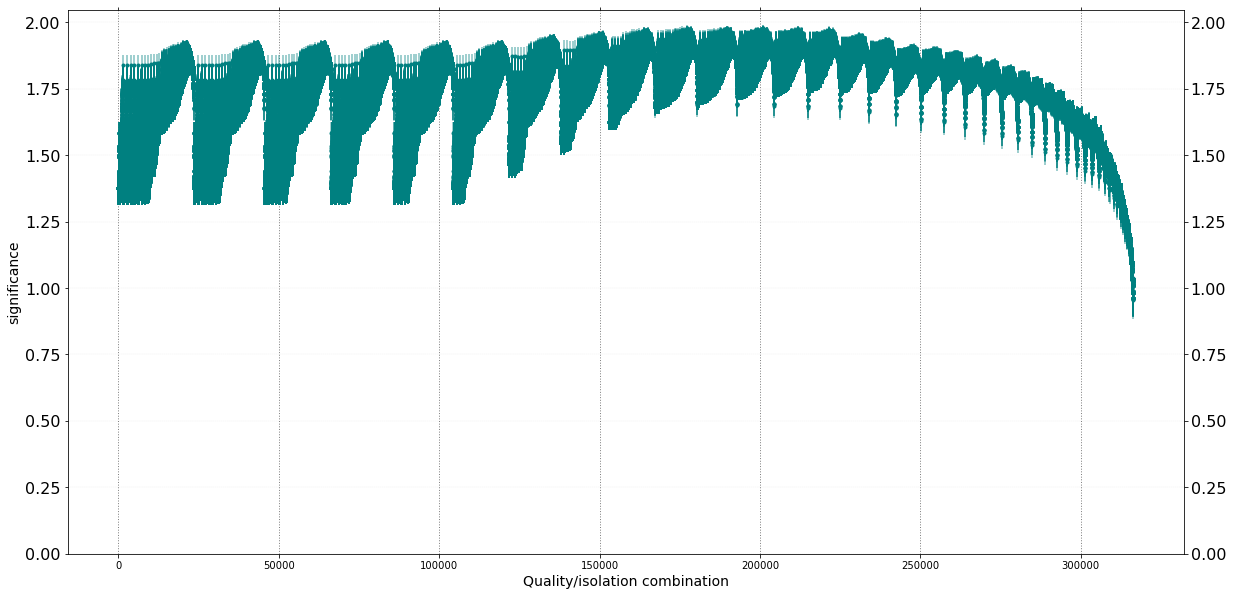

Initial significance:
1.38 ± 0.06

Maximum significance:
1.95 ± 0.04
when
pt_4 cut = 11.0 GeV
pt_3 cut = 24.0 GeV
pt_2 cut = 45.0 GeV
pt_1 cut = 50.0 GeV


In [86]:
x = range(total)

# Uncomment a block:

title = 'significance'
y     = pt_scan_df['significance']
y_err  = pt_scan_df['significance-err']
color = 'teal'

# title = 'SF-inZ-significance'
# y     = pt_scan_df['SF-inZ-significance']
# y_err  = pt_scan_df['SF-inZ-significance-err']
# color = 'teal'

# title = 'SF-noZ-significance'
# y     = pt_scan_df['SF-noZ-significance']
# y_err  = pt_scan_df['SF-noZ-significance-err']
# color = 'teal'

# title = 'DF-significance'
# y     = pt_scan_df['DF-significance']
# y_err  = pt_scan_df['DF-significance-err']
# color = 'teal'

# title = 'signal'
# y     = pt_scan_df['signal']
# y_err  = pt_scan_df['signal-err']
# color = 'crimson'

# title = 'SF-inZ-signal'
# y     = pt_scan_df['SF-inZ-signal']
# y_err  = pt_scan_df['SF-inZ-signal-err']
# color = 'crimson'

# title = 'SF-noZ-signal'
# y     = pt_scan_df['SF-noZ-signal']
# y_err  = pt_scan_df['SF-noZ-signal-err']
# color = 'crimson'

# title = 'DF-signal'
# y     = pt_scan_df['DF-signal']
# y_err  = pt_scan_df['DF-signal-err']
# color = 'crimson'

# title = 'background'
# y     = pt_scan_df['background']
# y_err  = pt_scan_df['background-err']
# color = 'blue'

# title = 'SF-inZ-background'
# y     = pt_scan_df['SF-inZ-background']
# y_err  = pt_scan_df['SF-inZ-background-err']
# color = 'blue'

# title = 'SF-noZ-background'
# y     = pt_scan_df['SF-noZ-background']
# y_err  = pt_scan_df['SF-noZ-background-err']
# color = 'blue'

# title = 'DF-background'
# y     = pt_scan_df['DF-background']
# y_err  = pt_scan_df['DF-background-err']
# color = 'blue'

y = np.array(y)
y_err = np.array(y_err)

plt.figure(figsize=[20,10]) 
plt.plot(x, y, 'o', color=color, markersize=3)
plt.errorbar(x, y, yerr=y_err, 
             fmt=' ', capsize=0, color=color, alpha=0.5)
plt.xlabel("Quality/isolation combination", fontsize=14)
# plt.xticks([0, 71, 143, 215, 287, 359, 431, 503, 575, 647], fontsize=10)
plt.ylabel(title, fontsize=14)
# plt.yscale('log')
# plt.ylabel('log({})'.format(title), fontsize=14)
plt.ylim(0)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True)
plt.yticks(fontsize=16)

plt.grid(axis="x", color="grey", alpha=1, linewidth=1, linestyle=":")
plt.grid(axis="y", color="grey", alpha=.5, linewidth=.25, linestyle=":")
plt.savefig('plots/Using_W_leptons_{}_{}.pdf'.format(title, identifier))
plt.show()

print('Initial significance:'.format(title))
print("{:.2f} ± {:.2f}".format( y[0], y_err[0] ))
print()

print('Maximum significance:'.format(title))
index_max = np.argmax(y)
print("{:.2f} ± {:.2f}".format(y[index_max], y_err[index_max]))
# print('at index: {}'.format(index_max))
print('when')

print("pt_4 cut = {} GeV".format(pt_scan_df['pt_4'][index_max]/1000))
print("pt_3 cut = {} GeV".format(pt_scan_df['pt_3'][index_max]/1000))
print("pt_2 cut = {} GeV".format(pt_scan_df['pt_2'][index_max]/1000))
print("pt_1 cut = {} GeV".format(pt_scan_df['pt_1'][index_max]/1000))